## Supernovae

###  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astroML

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

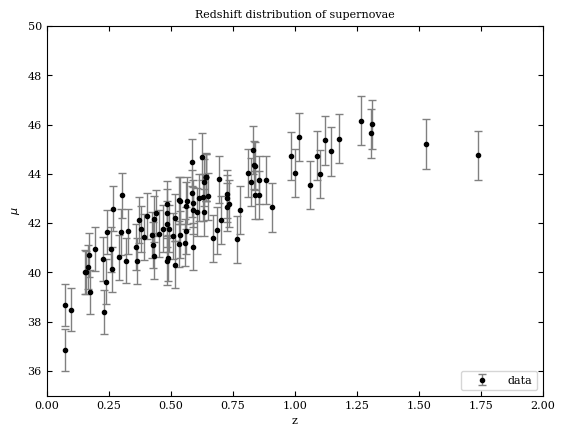

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Redshift distribution of supernovae')

x = np.array(z_sample)
y = np.array(mu_sample)

$\mu$ here is the magnitude

$$
    \mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

## Linear regression 

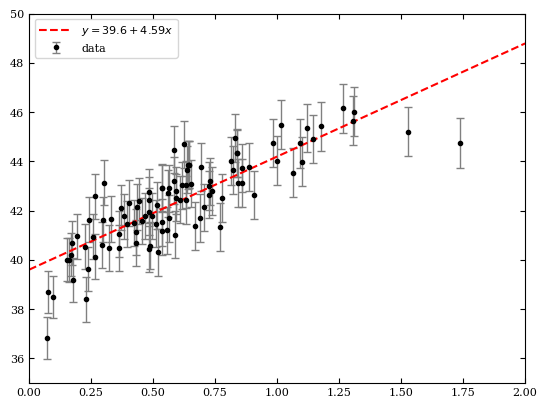

In [18]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
y = mu_sample

lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_[0]

x_new = np.array([[0], [2]]) #like X_grid, but just with the endpoints
y_pred = lin_reg.predict(x_new)

plt.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_new, y_pred, ls='--', c='red', label= fr'$y = {round(theta0,2)} + {round(theta1,2)}x$')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend();

## Polynomial

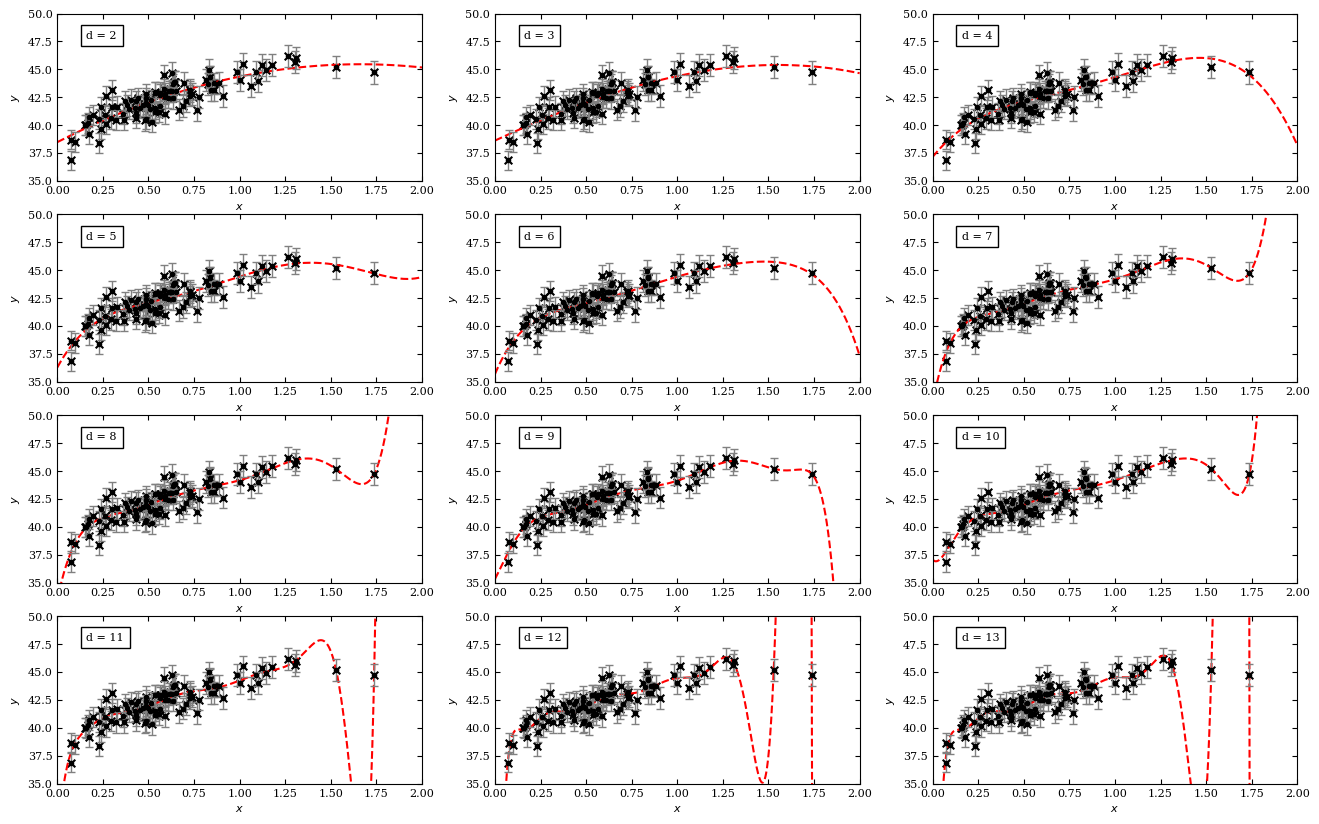

In [5]:
fig,axs = plt.subplots(4,3, figsize=(16,10))
c_axs = np.concatenate(axs)


d = np.arange(2,14)

for d_i, ax in zip(d, c_axs):
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d_i, w=dmu)
    x_fit = np.linspace(0, 2, 1000)
    y_fit = np.polyval(p, x_fit)


    ax.plot(x_fit, y_fit, c='r', ls='--')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.set_ylim(35,50)
    ax.set_xlim(0, 2)

    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.9, "d = %i" % d_i, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'));
    


### kfold cross validation

In [158]:
def k_cross_val(k, x, y, rank, dmu):
    x_n = np.array(np.split(x, 4))
    y_n = np.array(np.split(y, 4))
    dmu_n = np.array(np.split(dmu, 4))
    
    rsd = [] #residuals
    
    # defining sets
    for j in range(0,k):  
        x_cv = x_n[j]
        y_cv = y_n[j]
        dmu_cv = dmu_n[j] 

        xtrain = np.delete(x_n, np.argwhere(x_n==x_cv)).flatten() 
        ytrain = np.delete(y_n, np.argwhere(y_n==y_cv)).flatten() 
        dmu_t = np.delete(dmu_n, np.argwhere(dmu_n==dmu_cv)).flatten()
        
        p = np.polyfit(xtrain, ytrain, rank, w=dmu_t)

        rsd.append((y_cv - np.polyval(p, x_cv))**2/y_cv) 
        #it's better to normalize the distance by dividing for the true value
        
    #residuals for all validations sets, 
    #now we have the corresponding residuals for my 4 different models for every x
    #which should now cover the whole space
    rsd = np.array(rsd).flatten()
    rsd = np.sort(rsd)
    
    
    return rsd

(100,)


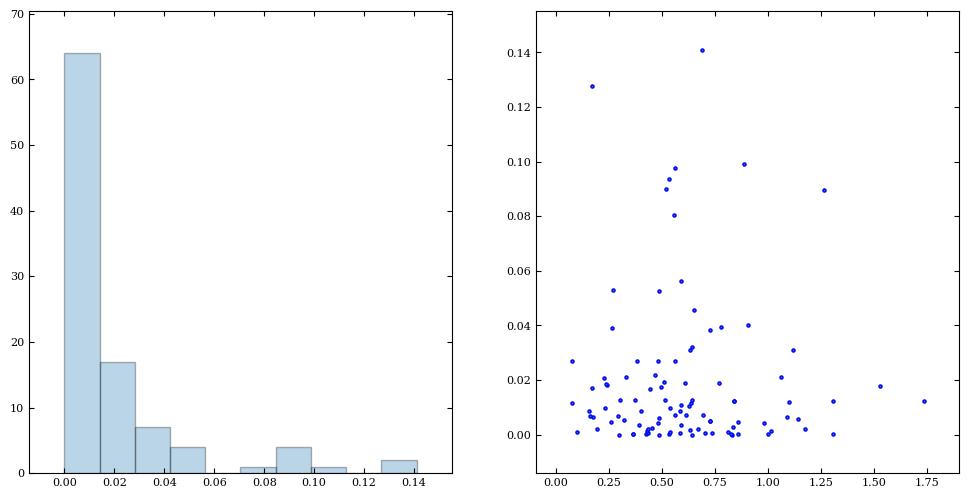

In [167]:
fig,axs = plt.subplots(1,2, figsize=(12,6))

rds = k_cross_val(4, x, y, 2, dmu)
print(rds.shape)
axs[0].hist(rds, alpha = .3)
axs[0].margins(.1)
axs[1].scatter(x, rds, s=5)
axs[1].margins(.1);

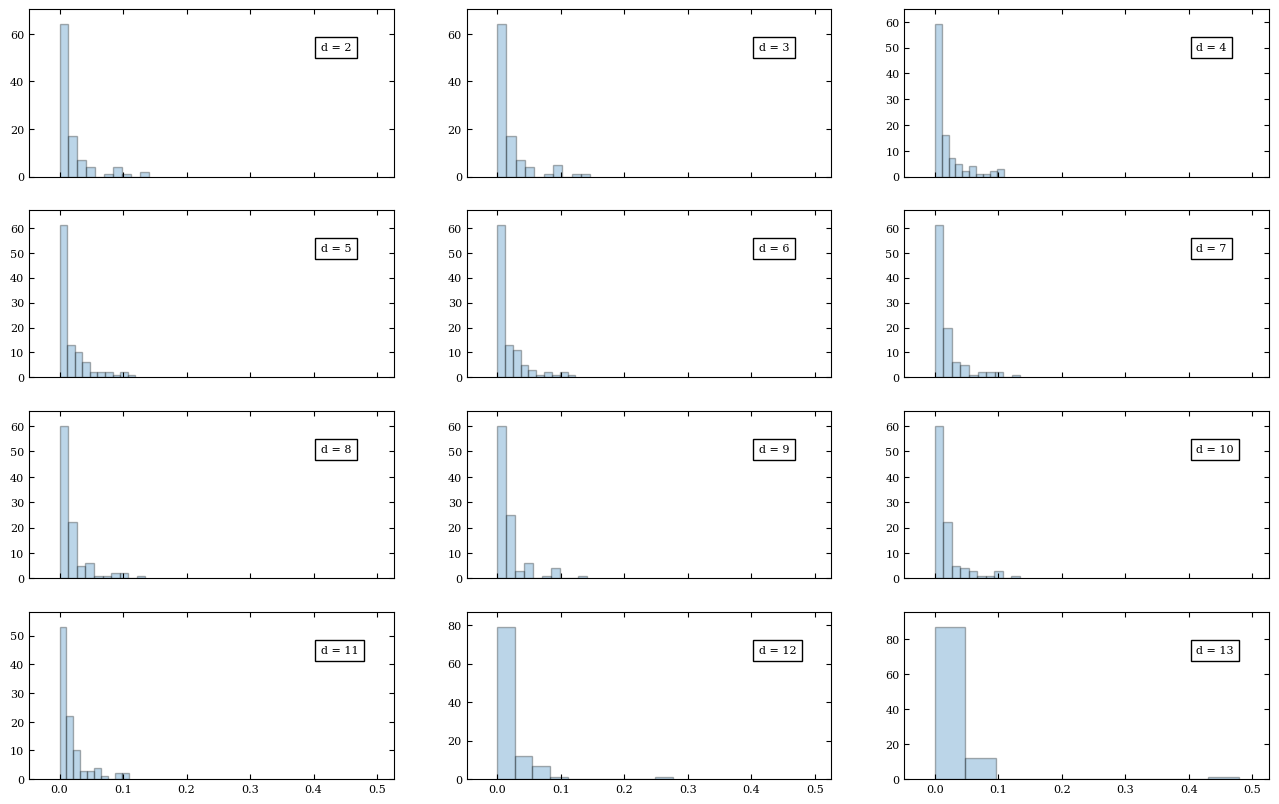

In [166]:
score = np.zeros(len(d))

fig,axs = plt.subplots(4,3, figsize=(16,10), sharex=True)
c_axs = np.concatenate(axs)

for i,d_i in enumerate(d):
    rds = k_cross_val(4, x, y, d_i, dmu)
    
    c_axs[i].hist(rds, alpha = .3, label=str(d_i))
    c_axs[i].margins(.1)
    c_axs[i].text(0.8, 0.8, "d = %i" % d_i, transform=c_axs[i].transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'))
    
    score[i] = np.sum(rds)

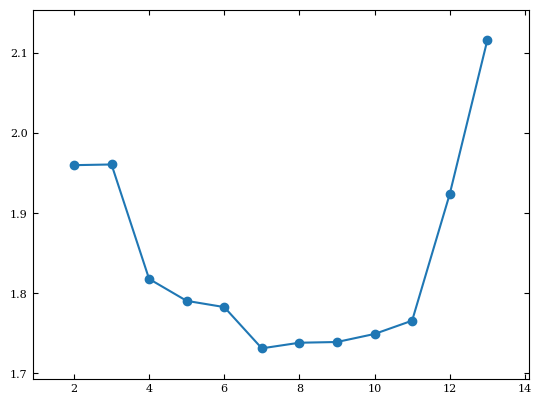

In [168]:
plt.plot(d,score, '-o')
plt.margins(.1);

Why does the error change so much by using different validation sets?

### How do i split the data?

I'm splitting data, but the data is not ordered so i don't see the gap in between

(0.0, 2.0)

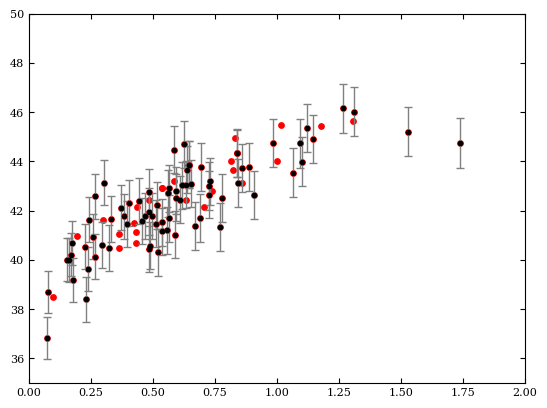

In [169]:
x_cv = x_n[0]
y_cv = y_n[0]
dmu_cv = dmu_n[0] 

xtrain = np.delete(x_n, np.argwhere(x_n==x_cv)).flatten() 
ytrain = np.delete(y_n, np.argwhere(y_n==y_cv)).flatten() 
dmu_t = np.delete(dmu_n, np.argwhere(dmu_n==dmu_cv)).flatten()

plt.errorbar(xtrain, ytrain, dmu_t, fmt='.k', ecolor='gray', lw=1,label='data')
plt.scatter(x, y, s=15,color='red')
plt.ylim(35,50)
plt.xlim(0, 2)

## Setting up a new CV algorithm

Using `GridSearchCV` doesn't work, i tried in many ways. I have to implement it myself, let's try to build a general function for all type of regressors.
I wanted to build a k-fold cv method so we will leave the option to split the data but i couldn't manage to do it

In [174]:
X = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

In [182]:
from sklearn.model_selection import train_test_split

X_train, X_cv, ydy_train, ydy_cv = train_test_split(X, np.array([y,dy]).T, test_size=0.25, random_state=42)
y_train,dy_train = ydy_train.T
y_cv,dy_cv = ydy_cv.T

In [183]:
def geterror(X,y,classifier):
    return np.sqrt( np.sum((y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    classifier.fit(X_train, y_train, dy_train)
    error_train = geterror(X_train, y_train, classifier)
    error_validation  = geterror(X_cv, y_cv, classifier)
    return error_train, error_validation

Let's test it out

In [184]:
classifier = astroML.linear_model.LinearRegression()
error_train, error_validation = fitanderror(classifier)
print("Linear Regression", error_train, error_validation)

Linear Regression 1.0331631897294864 0.834325298130462


---

## Basis function regression

In [185]:
#Basis function regression looks like this
from astroML.linear_model import BasisFunctionRegression

# data from linear regression scheme
X = x[:, np.newaxis]
y = mu_sample

xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,2,100)[:, None]
# widths of these Gaussians
s_test = np.linspace(1,12,6)

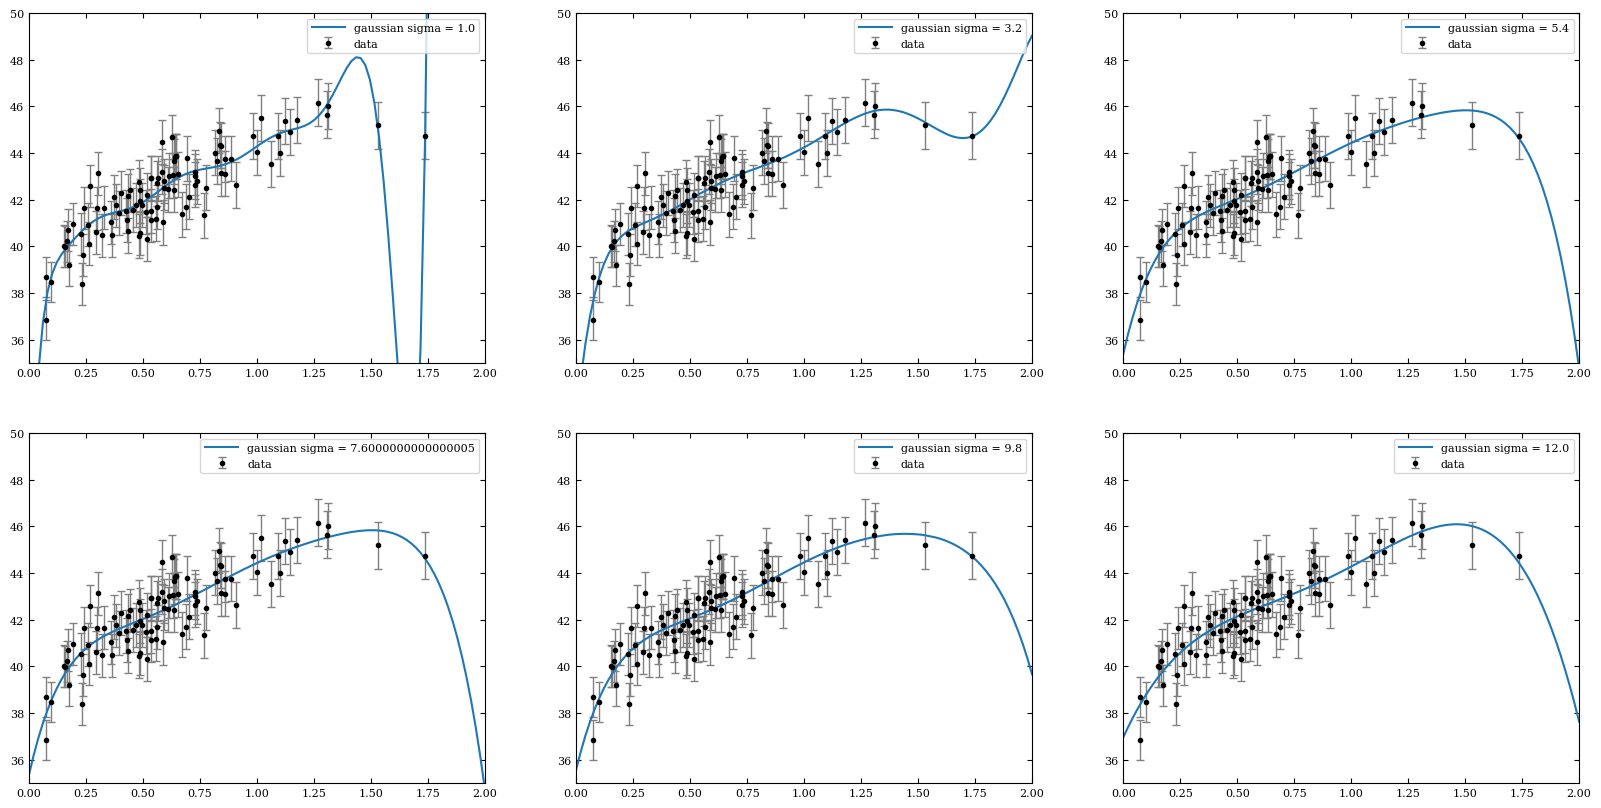

In [186]:
fig,axs = plt.subplots(2,3, figsize=(20,10))
c_axs = np.concatenate(axs)

for s, ax in zip(s_test,c_axs):
    bfr = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=s)
    bfr.fit(X,y,dmu)
    y_pred = bfr.predict(xgrid)
    
    ax.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.plot(xgrid, y_pred, label=f'gaussian sigma = {s}')
    
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)
    ax.legend(loc = 'upper right');

In [235]:
s_test = np.linspace(1,12,int(1e2))

etrain, etest= [], []

for s in s_test:
    bfr = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=s)
    error_train, error_cv = fitanderror(bfr)
    etrain.append(error_train)
    etest.append(error_cv)

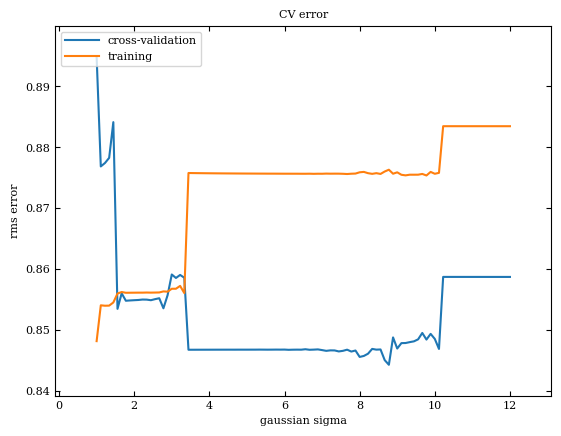

In [236]:
plt.plot(s_test, etest, label='cross-validation')
plt.plot(s_test, etrain, label='training')

plt.xlabel('gaussian sigma')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)

We can see in this case that there is an obvious overfit for low sigma, while a variance domination for high sigmas. Our best fit appears to be at sigma between 2 and 3

### Learning curves
Are 100 points enough information to get an accurate fit? I doubt so, let's look at the learning curves

In [216]:
def learing_curve_error(classifier, N):
    classifier.fit(X[:N], y[:N], dmu[:N])
    error_train = geterror(X[:N], y[:N], classifier)
    error_validation  = geterror(X_cv, y_cv, classifier)
    return error_train, error_validation

In [251]:
N = np.linspace(2,100,50).astype(int)

etrain, etest= [], []

for n in N:
    bfr = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=3.2)
    error_train, error_cv = learing_curve_error(bfr, n)
    etrain.append(error_train)
    etest.append(error_cv)

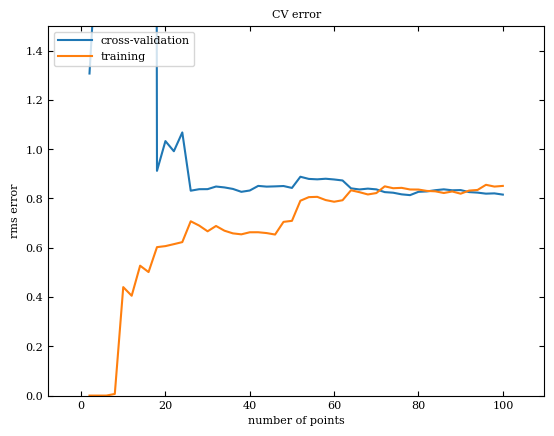

In [252]:
plt.plot(N, etest, label='cross-validation')
plt.plot(N, etrain, label='training')
plt.ylim(0,1.5)

plt.xlabel('number of points')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)

## Kernel function regression

In [240]:
from astroML.linear_model import NadarayaWatson

X = x[:, np.newaxis]
y = mu_sample

xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

# widths of these Gaussians
h_test = [.01, .05, .1, .25, .5, 1]

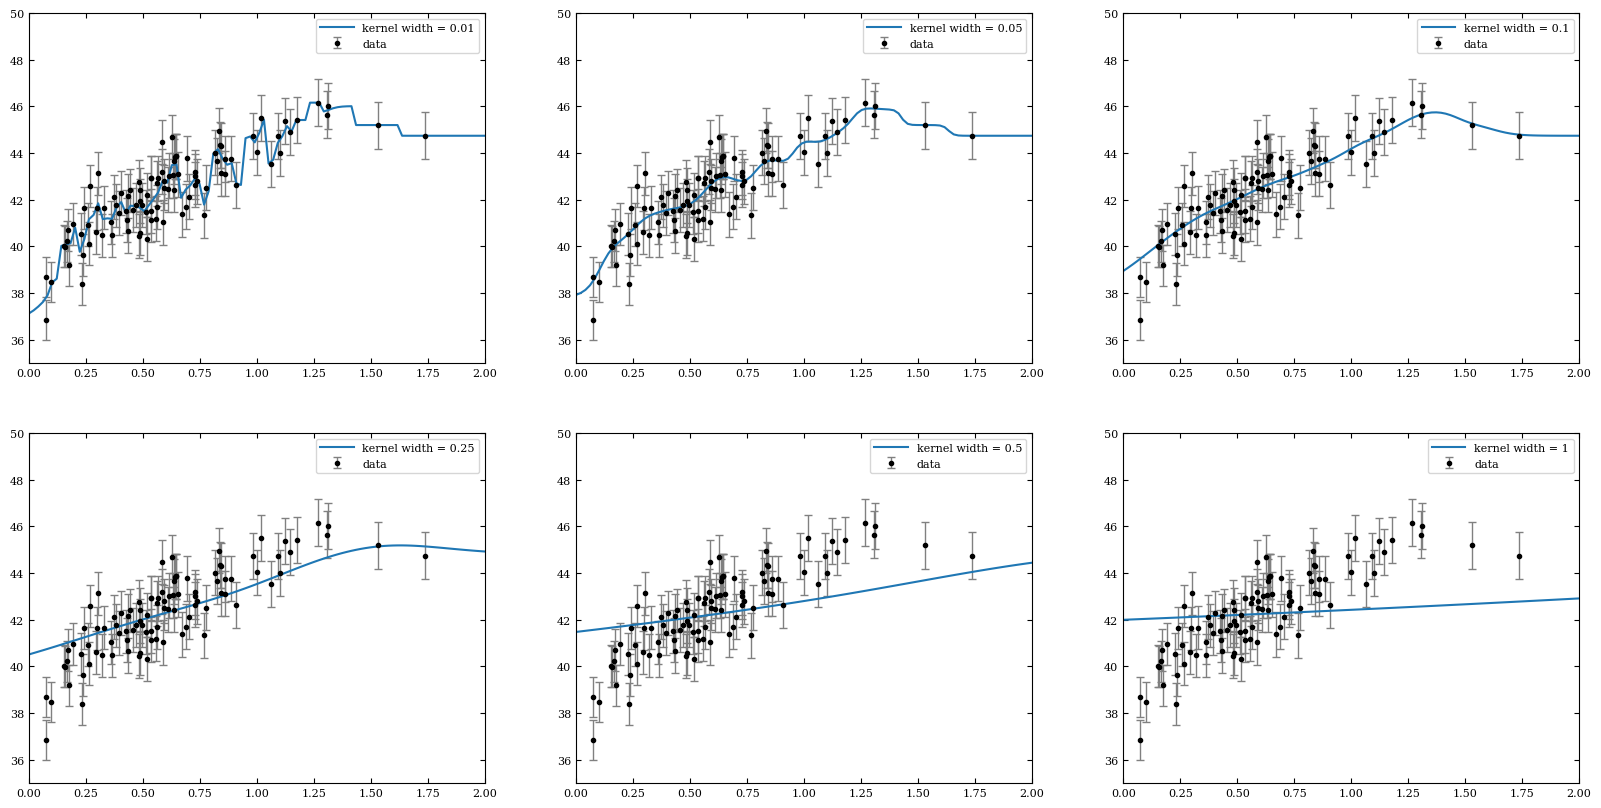

In [241]:
fig,axs = plt.subplots(2,3, figsize=(20,10))
c_axs = np.concatenate(axs)

for h, ax in zip(h_test,c_axs):
    kfr = NadarayaWatson(kernel='gaussian', h=h)
    kfr.fit(X,y,dmu)
    y_pred = kfr.predict(xgrid)
    
    ax.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.plot(xgrid, y_pred, label=f'kernel width = {h}')
    
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)
    ax.legend();

In [242]:
h_test = np.linspace(.01,2,int(1e2))

etrain, etest= [], []

for h in h_test:
    kfr = NadarayaWatson(kernel='gaussian', h=h)
    error_train, error_cv = fitanderror(kfr)
    etrain.append(error_train)
    etest.append(error_cv)

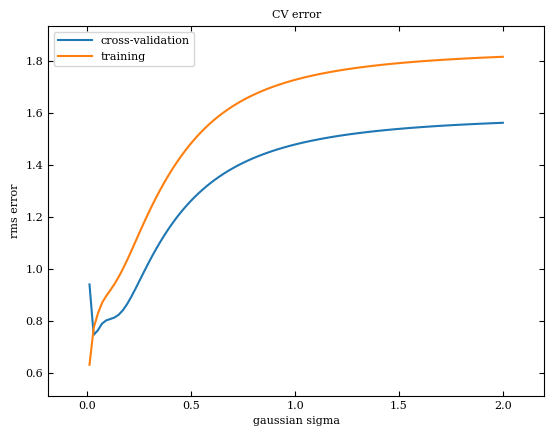

In [243]:
plt.plot(h_test, etest, label='cross-validation')
plt.plot(h_test, etrain, label='training')

plt.xlabel('gaussian sigma')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)

In [246]:
N = np.linspace(2,100,50).astype(int)

etrain, etest= [], []

h=0.2

for n in N:
    kfr = NadarayaWatson(kernel='gaussian', h=h)
    error_train, error_cv = learing_curve_error(kfr, n)
    etrain.append(error_train)
    etest.append(error_cv)
    

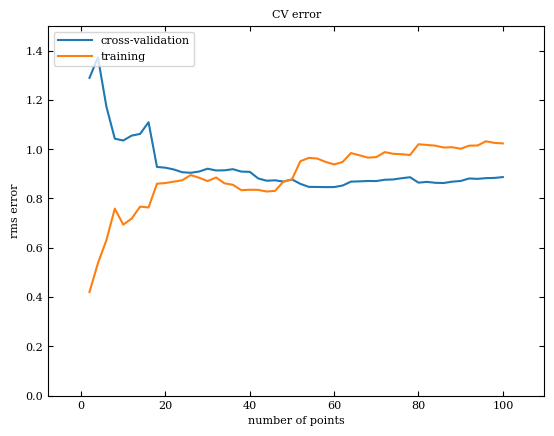

In [249]:
plt.plot(N, etest, label='cross-validation')
plt.plot(N, etrain, label='training')
plt.ylim(0,1.5)

plt.xlabel('number of points')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)